In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geodatasets as gds
import folium
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
listings = pd.read_csv("listings.csv")

In [3]:
listings

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,6983,https://www.airbnb.com/rooms/6983,20220924142144,2022-09-24,previous scrape,Copenhagen 'N Livin',Lovely apartment located in the hip Nørrebro a...,"Nice bars and cozy cafes just minutes away, ye...",https://a0.muscache.com/pictures/42044170/f63c...,16774,...,4.89,4.73,4.71,NaN,f,1,1,0,0,1.08
1,26057,https://www.airbnb.com/rooms/26057,20220924142144,2022-09-25,city scrape,Lovely house - most attractive area,Our lovely house in the center of the city is ...,The neighborhood is the most famous one and th...,https://a0.muscache.com/pictures/miso/Hosting-...,109777,...,4.86,4.94,4.81,NaN,f,1,1,0,0,0.55
2,26473,https://www.airbnb.com/rooms/26473,20220924142144,2022-09-25,city scrape,City Centre Townhouse Sleeps 1-10 persons,GUESTHOUSE ON KNABROSTRÆDE - located in the ab...,NaN,https://a0.muscache.com/pictures/8e132ba0-b68c...,112210,...,4.70,4.89,4.59,NaN,f,3,3,0,0,2.06
3,29118,https://www.airbnb.com/rooms/29118,20220924142144,2022-09-25,city scrape,Best Location in Cool Istedgade,<b>The space</b><br />The apartment is situate...,NaN,https://a0.muscache.com/pictures/b83c7003-367a...,125230,...,5.00,4.87,4.80,NaN,f,1,1,0,0,0.16
4,31094,https://www.airbnb.com/rooms/31094,20220924142144,2022-09-24,previous scrape,"Beautiful, spacious, central, renovated Penthouse","Welcome to our home, we hope you will enjoy Wo...","What else is nearby?<br />To be honest, We thi...",https://a0.muscache.com/pictures/miso/Hosting-...,129976,...,4.82,4.80,4.53,NaN,f,1,1,0,0,0.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13810,653494030951422457,https://www.airbnb.com/rooms/653494030951422457,20220924142144,2022-09-25,previous scrape,Top-floor Villa Apartment in the Heart of Hell...,Family apartment located on the 1st floor of a...,The apartment is located one block from Strand...,https://a0.muscache.com/pictures/miso/Hosting-...,465189427,...,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN
13811,647809303952891559,https://www.airbnb.com/rooms/647809303952891559,20220924142144,2022-09-25,previous scrape,Dejligt lille hus med flere hyggekroge ude og ...,Lille villa i roligt kvarter 15 min fra Københ...,"Nice green areas, football field, lake, playgr...",https://a0.muscache.com/pictures/b466ccb0-cef0...,4862421,...,5.00,4.67,5.00,NaN,f,1,1,0,0,1.01
13812,650819220455514228,https://www.airbnb.com/rooms/650819220455514228,20220924142144,2022-09-25,previous scrape,Lejlighed i Storkøbenhavn. 13 minutter fra cen...,"Smuk og hyggelig lejlighed tæt på Hvidovre st,...",NaN,https://a0.muscache.com/pictures/miso/Hosting-...,134647873,...,5.00,4.67,5.00,NaN,t,1,1,0,0,1.27
13813,658612163688161695,https://www.airbnb.com/rooms/658612163688161695,20220924142144,2022-09-25,previous scrape,Cosy apartment with a great view in Copenhagen,Well located apartment close to grocery stores...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,256903668,...,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN


In [4]:
#1)Dropping unwanted columns:
columns_to_keep = ['id', 'name', 'host_id', 'host_name', 'neighbourhood_cleansed', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
listings = listings[columns_to_keep]

In [5]:
#2)drop all rows that number_of_reviews=0:
listings = listings[listings['number_of_reviews'] != 0]
listings = listings.dropna()

In [6]:
#3)Fix the 'neighbourhood_cleansed' values (some are missing 'æ ø å')
listings['neighbourhood_cleansed'] = listings['neighbourhood_cleansed'].str.replace('ae', 'æ').str.replace('oe', 'ø').str.replace('aa', 'å')

In [7]:
#Change the price to DKK
exchange_rate = 6.9
listings['price'] = listings['price'].str.replace('$', '').str.replace(',', '').astype(float) * exchange_rate

In [8]:
#4)Create a fitting word cloud based on the 'name' column
house_name = listings["name"]
house_name

0                                     Copenhagen 'N Livin'
1                      Lovely house - most attractive area
2                City Centre Townhouse Sleeps 1-10 persons
3                          Best Location in Cool Istedgade
4        Beautiful, spacious, central, renovated Penthouse
                               ...                        
13808            Ny rummelig lejlighed med tilhørende kat.
13809                 Big beautiful and charming apartment
13811    Dejligt lille hus med flere hyggekroge ude og ...
13812    Lejlighed i Storkøbenhavn. 13 minutter fra cen...
13814       Big Bedroom connected with a large living room
Name: name, Length: 12126, dtype: object

In [9]:
#5)Provide a word cloud of the names of the hosts, removing any names of non-persons
host_name = listings["host_name"]
host_name

0           Simon
1            Kari
2           Julia
3            Nana
4            Ebbe
           ...   
13808      Morten
13809       Tanja
13811    Kathrine
13812         Tim
13814       Tanja
Name: host_name, Length: 12126, dtype: object

In [10]:
#6)Create a new column using bins of price. Use 11 bins, evenly distributed but with the last bin $> 10,000$.
bin_edges = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, np.inf]

bin_labels = ['0-1000', '1001-2000', '2001-3000', '3001-4000', '4001-5000', '5001-6000',
              '6001-7000', '7001-8000', '8001-9000', '9001-10000','>10000']
              
listings['price_bin'] = pd.cut(listings['price'], bins=bin_edges, labels=bin_labels, right=False)

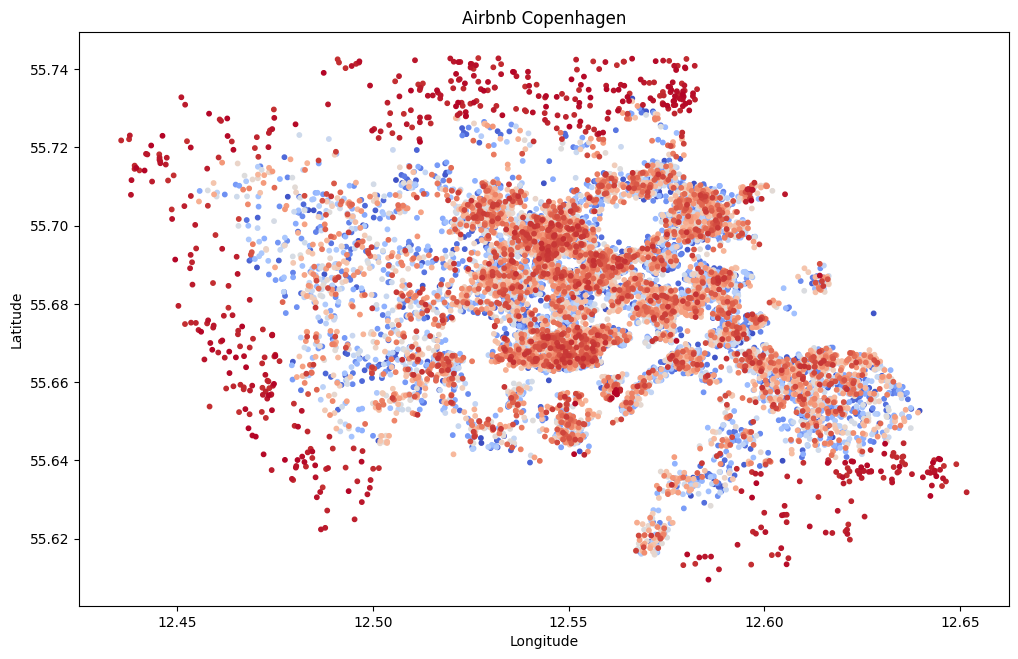

In [11]:
#7)Using non-scaled versions of latitude and longitude, plot the listings data on a map.
gdf = gpd.GeoDataFrame(listings, 
                       geometry=gpd.points_from_xy(listings.longitude, listings.latitude))

# Create a scatter plot with price as the color parameter
fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot(ax=ax, markersize=10, c='price', cmap='coolwarm', legend=True)

# Set plot title and labels
plt.title('Airbnb Copenhagen')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

c:\Users\fhuur\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\fhuur\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\fhuur\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


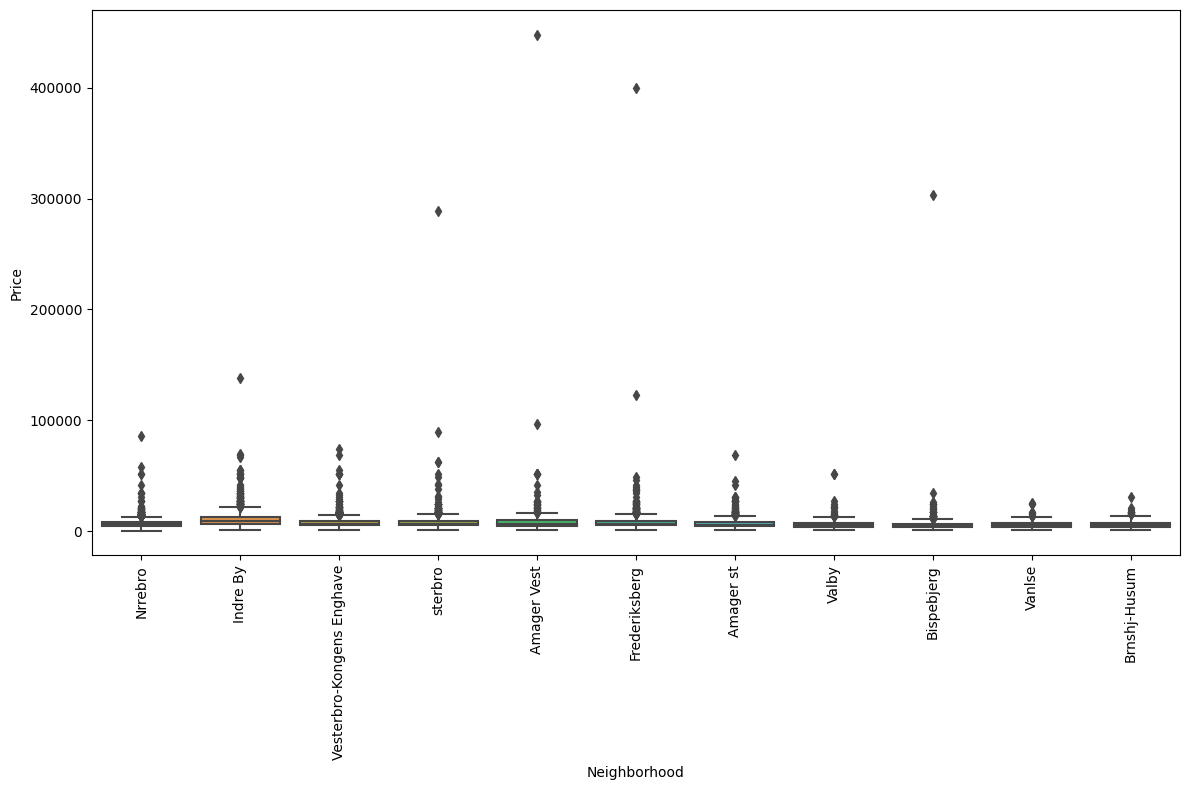

In [12]:
#8)Create boxplots where you have the neighbourhood on the x-axis and price on the y-axis
plt.figure(figsize=(12, 8))
sns.boxplot(x="neighbourhood_cleansed", y="price", data=listings)

plt.xticks(rotation=90)

plt.xlabel('Neighborhood')
plt.ylabel('Price')

plt.tight_layout()
plt.show()

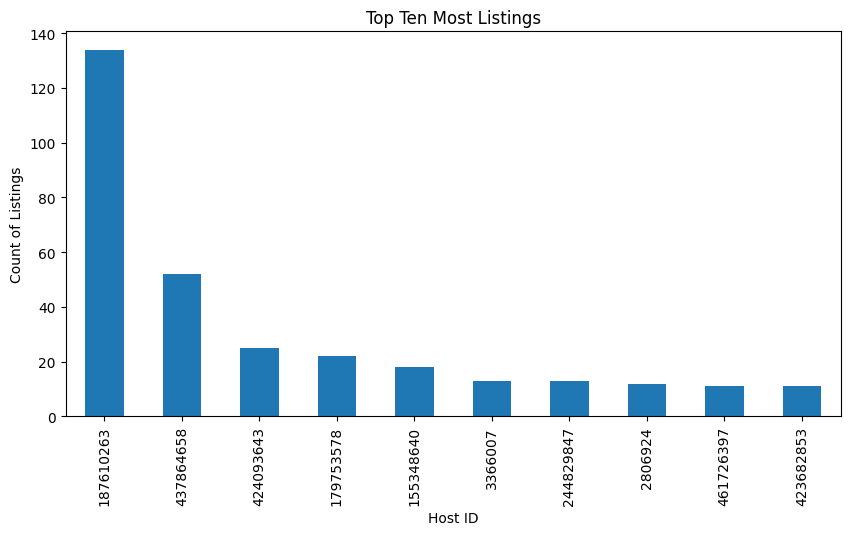

In [13]:
#9)Create a bar chart of the hosts with the top ten most listings. Place host id on the x-axis and the count of listings on the y-axis.
top_hosts = listings['host_id'].value_counts().head(10)
top_hosts.plot(kind='bar', figsize=(10, 5))
plt.xlabel('Host ID')
plt.ylabel('Count of Listings')
plt.title('Top Ten Most Listings')
plt.show()

In [14]:
#10)Do a descriptive analysis of the neighborhoods. Include information about room type in the analysis as well as one other self-chosen feature.
room_type_mode = listings['room_type'].mode()[0]

price_mean = listings['price'].mean()
price_median = listings['price'].median()
price_std = listings['price'].std()
price_min = listings['price'].min()
price_max = listings['price'].max()

neighborhood_stats = {
    'room_type_mode': room_type_mode,
    'price_mean': price_mean,
    'price_median': price_median,
    'price_std': price_std,
    'price_min': price_min,
    'price_max': price_max,
}

display(neighborhood_stats)

{'room_type_mode': 'Entire home/apt',
 'price_mean': 7972.638743196438,
 'price_median': 6755.1,
 'price_std': 8532.995463205814,
 'price_min': 545.1,
 'price_max': 447810.0}

In [15]:
#11)Supply a list of the top 10 highest rated listings and visualize them on a map.
copenhagen_map = folium.Map(location=[55.6761, 12.5683], zoom_start=13)

top_10_listings = listings.sort_values(by='review_scores_rating', ascending=False).head(10)

for index, row in top_10_listings.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['name'],
        icon=folium.Icon(color='red')
    ).add_to(copenhagen_map)

display(copenhagen_map)

In [16]:
#12)Now, use any preprocessing and feature engineering steps that you find relevant before proceeding (optional)
#13)Create another new column, where the price is divided into two categories: "expensive" listings defined by all listings with a price higher than the median price, and "affordable" listings defined by all listings with a price equal to or below the median price. You can encode the affordable listings as "0" and the expensive ones as "1". All listings should now have a classification indicating either expensive listings (1) or affordable listings (0).
median_price = listings['price'].median()

# Create a new column 'price_category' where expensive listings are encoded as 1 and affordable as 0
listings['price_category'] = (listings['price'] > median_price).astype(int)

In [18]:
#14)Based on self-chosen features, develop a Naïve Bayes and k-Nearest Neighbor model to determine whether a rental property should be classified as 0 or 1. Remember to divide your data into training data and test data. Comment on your findings.
# Split the data into training and test sets
X = listings[['latitude', 'longitude']]  # Add more features as needed
y = listings['price_category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Naïve Bayes model
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)

# Make predictions using the Naïve Bayes model
naive_bayes_predictions = naive_bayes.predict(X_test)

# Evaluate the Naïve Bayes model
naive_bayes_accuracy = accuracy_score(y_test, naive_bayes_predictions)
naive_bayes_report = classification_report(y_test, naive_bayes_predictions)

print("Naïve Bayes Accuracy:", naive_bayes_accuracy)
print("Naïve Bayes Classification Report:\n", naive_bayes_report)

# Train a k-Nearest Neighbor (k-NN) model
knn = KNeighborsClassifier(n_neighbors=5)  # You can choose the number of neighbors (k) as needed
knn.fit(X_train, y_train)

# Make predictions using the k-NN model
knn_predictions = knn.predict(X_test)

# Evaluate the k-NN model
knn_accuracy = accuracy_score(y_test, knn_predictions)
knn_report = classification_report(y_test, knn_predictions)

print("k-NN Accuracy:", knn_accuracy)
print("k-NN Classification Report:\n", knn_report)

Naïve Bayes Accuracy: 0.5972794723825227
Naïve Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.45      0.52      1176
           1       0.59      0.73      0.65      1250

    accuracy                           0.60      2426
   macro avg       0.60      0.59      0.59      2426
weighted avg       0.60      0.60      0.59      2426

k-NN Accuracy: 0.5997526793075021
k-NN Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.61      0.60      1176
           1       0.62      0.59      0.60      1250

    accuracy                           0.60      2426
   macro avg       0.60      0.60      0.60      2426
weighted avg       0.60      0.60      0.60      2426



In [19]:
'''The overall accuracy of the k-NN model is approximately 0.60, indicating that it correctly classified about 60% of the samples.'''

'The overall accuracy of the k-NN model is approximately 0.60, indicating that it correctly classified about 60% of the samples.'

In [ ]:
#15)Try to come up with a final conclusion to the Airbnb-Copenhagen assignment

'''
This assignment taught me the process of data analysis, first we need to preprocess the data, leaving only the needed data and removing invalid data such as zeros or errors.Then analyze it step by step.

This assignment also taught me to draw maps using latitude, longitude and other parameters, and in my opinion folium works better than geopandas, the maps are very clear and detailed and colored.

This assignment also taught me to fix problematic data, such as uniform symbols. It also taught me to create new columns to get the data we want.'''


'\nThis assignment taught me the process of data analysis, first we need to preprocess the data, leaving only the needed data and removing invalid data such as zeros or errors.Then analyze it step by step.\n\nThis assignment also taught me to draw maps using latitude, longitude and other parameters, and in my opinion folium works better than geopandas, the maps are very clear and detailed and colored.\n\nThis assignment also taught me to fix problematic data, such as uniform symbols. It also taught me to create new columns to get the data we want.'